In [1]:
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm
import numpy as np
import random

In [2]:
df = pd.read_csv('imdb_dataset.tsv', sep='\t', header=None, dtype=str)
print(df.dtypes)

0    object
1    object
dtype: object


In [3]:
edges = df.to_records(index=False)

In [4]:
df[2] = df[1].str.extract(r'(\(\d{4})', expand=True)#.str.replace("(", "").fillna(0).astype(int) #FIXME fillna is pretty ugly rn
df[2] = df[2].str.replace("(", "", regex=False).fillna(0).astype(int)


In [5]:
df[2]

0          1986
1          1985
2          2003
3          1999
4          2011
           ... 
8104330    1962
8104331    2012
8104332    1980
8104333    2004
8104334    1995
Name: 2, Length: 8104335, dtype: int64

In [6]:
#https://pandas.pydata.org/docs/reference/api/pandas.Series.str.extract.html
# I think the simple regex is sufficient
df = df.rename(columns={0: "actor", 1: "movie", 2: "year"})

In [7]:
print(df[df['year'].isnull()])

Empty DataFrame
Columns: [actor, movie, year]
Index: []


In [8]:
df[13500:13505]

,actor,movie,year
13500,"Abud, Machfud",Darah perjaka (1985),1985
13501,"Abud, Machfud",Perawan disarang sindikat (1987),1987
13502,"Abud, Machfud",Siluman kera (1988),1988
13503,"Abud, Machfud",Tarzan raja rimba (1989),1989
13504,"Abud, Mariano",Un Bu?uel mexican (1997),1997


In [9]:
df.loc[df['movie'] == 'Re']
df['movie'] = df['movie'].replace(['Re'],'Re ')
df['movie'] = df['movie'].replace(['Regen'], 'Regen ')

In [10]:
df.loc[df['movie'] == 'Re ']


,actor,movie,year
1493628,"Ferreira, Alexandre (I)",Re,0
7296249,"Pinto, In?s Vaz",Re,0


In [11]:
actors = df.actor.unique()
movies = df.movie.unique()
print(f"Number of actors is: {len(actors)} \nNumber of movies is: {len(movies)} \nTotal nodes will be: {actors.size + movies.size}")
print(f"Number of edges is will be: {len(edges)}")


Number of actors is: 2364796 
Number of movies is: 745941 
Total nodes will be: 3110737
Number of edges is will be: 8104335


In [12]:
movies_dict = df.drop(columns='actor').drop_duplicates().set_index('movie').to_dict('index')
movies_tuples_list = [(k, v) for k, v in movies_dict.items()] #ugly but convenient for what networkx expects

In [13]:
movies_tuples_list

[('Nykytaiteen museo (1986)', {'year': 1986}),
 ('Suuri illusioni (1985)', {'year': 1985}),
 ('E.R. Sluts (2003) (V)', {'year': 2003}),
 ('American Pimp (1999)', {'year': 1999}),
 ('Beats, Rhymes & Life: The Travels of a Tribe Called Quest (2011)',
  {'year': 2011}),
 ('Gangsta Rap: The Glockumentary (2007)', {'year': 2007}),
 ('Get It Where You Fit in 1 (2003) (V)', {'year': 2003}),
 ('Ghetto Physics (2010)', {'year': 2010}),
 ('Ghostride the Whip (2008) (V)', {'year': 2008}),
 ('Hip Hop Uncensored Vol. 4: Miami Vice (2002) (V)', {'year': 2002}),
 ('Menace II Society (1993)', {'year': 1993}),
 ('Ozone West 3 (2009) (V)', {'year': 2009}),
 ('Pimpalation: Return of the Trill (2006)', {'year': 2006}),
 ('Planet Rock: The Story of Hip-Hop and the Crack Generation (2011) (TV)',
  {'year': 2011}),
 ('Porndogs: The Adventures of Sadie (2009)', {'year': 2009}),
 ('Rhyme & Reason (1997)', {'year': 1997}),
 ('Scarface: Greatest Hits on DVD (2003) (V)', {'year': 2003}),
 ('Stop Pepper Palmer (20

In [14]:
oriGinal = nx.Graph()
oriGinal.add_nodes_from(actors, bipartite = 0) #attribute bipartite following documentation recommendations. In this case 0 is actors, 1 is movies
print(f"Number of nodes after adding actors is {oriGinal.number_of_nodes()}")
oriGinal.add_nodes_from(movies_tuples_list, bipartite = 1)
print(f"Number of nodes after adding movies is {oriGinal.number_of_nodes()}") 
      

Number of nodes after adding actors is 2364796
Number of nodes after adding movies is 3110737


In [60]:
# alternative to cell above
if False:
    oriGinal = nx.Graph()
    oriGinal.add_nodes_from(actors, bipartite = 0) #attribute bipartite following documentation recommendations. In this case 0 is actors, 1 is movies
    num_node_actors = oriGinal.number_of_nodes()
    print(f"Number of nodes after adding actors is {num_node_actors}")
    regens = []
    i = 0
    dump = None
    first = True
    second = True
    for nd in tqdm(movies_tuples_list):
        if nd[0] == 'Foundation of a Movie (2008)':
            regens.append(nd)
        oriGinal.add_node(nd[0], bipartite = 1, year = nd[1]['year'])
        i+=1
        if oriGinal.number_of_nodes() == i + num_node_actors -1 and first:
            print(f"Just tried to add {nd}, iteration {i}")
            first = False
        if oriGinal.number_of_nodes() == i + num_node_actors - 2 and second:
            print(f"Just tried to add {nd}, iteration {i}")
            second = False
        if nd[0] == 'Regen' or nd[0] == 'Re':
            print(f"->{nd}")
        if nd[1]['year'] == 10000:
            print(f"@@ {nd}")
    print(f"num iterations {i}")

    print(f"Number of nodes after adding movies is {oriGinal.number_of_nodes()}") #???????
    print(f"Number of actor nodes is {num_node_actors}, number of iterations is {i}, sum is {num_node_actors + i}")
      

In [15]:
print(movies_tuples_list[68079])


('Foundation of a Movie (2008)', {'year': 2008})


In [15]:
oriGinal.add_edges_from(edges)
print(oriGinal.number_of_edges())

8103960


In [16]:
G = nx.convert_node_labels_to_integers(oriGinal, label_attribute='original_name')

In [17]:
actor_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
movies_nodes = set(G) - actor_nodes

In [17]:
print(G[400000])

{}


In [20]:
#TODO asserts
print(f"Number of actor nodes: {len(actor_nodes)}")
print(f"Number of movies nodes: {len(movies_nodes)}")
print(f"Total number of nodes: {len(actor_nodes) + len(movies_nodes)}")

print(f"#Nodes? {oriGinal.number_of_nodes() == G.number_of_nodes()}")
print(f"#Edges? {oriGinal.number_of_edges() == G.number_of_edges()}")

Number of actor nodes: 2364796
Number of movies nodes: 745941
Total number of nodes: 3110737
#Nodes? True
#Edges? True


In [21]:
print(oriGinal)

Graph with 3110737 nodes and 8103960 edges


In [22]:
print(oriGinal["'t Hoen, Dani?l"])
print(oriGinal["'Kid Niagara' Kallet, Harry"])

print(G[2151046])

nodes_data = G.nodes.data(True)
print(nodes_data[2365734])

{'Zonde (2010)': {}}
{'Drug Demon Romance (2012)': {}}
{25695: {}, 207265: {}, 457200: {}, 472789: {}, 1009276: {}, 1140040: {}, 1486377: {}, 1751991: {}, 2036767: {}, 2816091: {}, 2313367: {}}
{'bipartite': 1, 'year': 2011, 'original_name': 'To Meet It with Awe (2011)'}


In [ ]:
original_data = oriGinal.nodes.data(True)
print(original_data['To Meet It with Awe (2011)'])

In [ ]:
G.size

In [21]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

## Question 1
G) Considering only the movies up to year x with x in {1930,1940,1950,1960,1970,1980,1990,2000,2010,2020}, write a function which, given x, computes the average number of movies per actor up to year x. 

In [21]:
def avgMoviesPerActorUpToYear(graph, act_nodes, mv_nodes, year):
    # get movies nodes up to a certain year
    movies_up_to_year = {x for x,y in graph.nodes(data=True) if y['bipartite'] == 1 and y['year'] <= year}
    # 
    nodes_subset = movies_up_to_year.union(act_nodes) 
    # We have two ways of interpreting the question. One is to consider actors even when they've zero movies, the 
    # other is to consider actors only when they have a non zero counter. Regardless, this is considered later
    subgraph = graph.subgraph(nodes_subset)
    assert subgraph.number_of_nodes() == len(nodes_subset)
    
    subgraph_actor_nodes = {n for n, d in subgraph.nodes(data=True) if d["bipartite"] == 0} #in this case it's not necessary because actors are first nodes (in order), but what I said is not a given
    
    degrees = subgraph.degree(nbunch = subgraph_actor_nodes)
    deg_data = pd.DataFrame(degrees)
    print(deg_data[1])
    sol = (year, deg_data[1].mean(), deg_data[1].replace(0, np.NaN).mean()) #convenient for output later
    #print(f"Mean: {sol[1]}")
    #print(f"Mean removing zeros: {sol[2]}")
    return sol
    
    #print(a)

In [22]:
print(avgMoviesPerActorUpToYear(G, actor_nodes, movies_nodes, 1970))

0          0
1          0
2          0
3          0
4          0
          ..
2364791    0
2364792    0
2364793    0
2364794    0
2364795    0
Name: 1, Length: 2364796, dtype: int64
(1970, 0.0, nan)


In [24]:
for year in range(1930, 2021, 10):
    print(avgMoviesPerActorUpToYear(G, actor_nodes, movies_nodes, year))


(1930, 0.16629989758093094, 6.18496791645697)
(1940, 0.303672539764563, 6.929682524365531)
(1950, 0.4303372725066116, 7.179201557660969)
(1960, 0.5872376198518772, 6.7980360193656715)
(1970, 0.786403382281924, 6.217696718433943)
(1980, 1.0331229696963034, 5.560324089352163)
(1990, 1.3526522817632318, 4.893006066650554)
(2000, 1.816060510978969, 4.343798170482544)
(2010, 2.9111114963924978, 3.623355084828727)
(2020, 3.4247304416367768, 3.426930244288014)


## Question 2
3) Considering only the movies up to year x with x in {1930,1940,1950,1960,1970,1980,1990,2000,2010,2020} and restricting to the largest connected component of the graph. Approximate the closeness centrality for each node. Who are the top-10 actors?

[Fast Approximation of Centrality (D. Eppstein, J. Wang)](https://www.ics.uci.edu/~eppstein/pubs/EppWan-SODA-01.pdf)
```
*Pseudocode
1. Let k be the number of iterations needed to obtain the desired error bound
2. In iteration i, pick vertex v_i uniformly at random from G and solve the SSSP problem with v_i as a source. 
3. Let (1) be the centrality estimator for vertex u
```
Where  
(1)  $\hat{c}_u = \frac{1}{\sum_{i=1}^k \frac{n*d(v_i, u)}{k(n-1)}}$

In [21]:
def closenessCentralityUpToYear(graph, act_nodes, year, k = None, epsilon = None):
    movies_up_to_year = {x for x,y in graph.nodes(data=True) if y['bipartite'] == 1 and y['year'] <= year}
    nodes_subset = movies_up_to_year.union(act_nodes) 
    cc_subgraph = graph.subgraph(nodes_subset)
    largest_cc = max(nx.connected_components(cc_subgraph), key=len) # get largest CC 
    cc_subgraph = graph.subgraph(largest_cc)
    assert cc_subgraph.number_of_nodes() == len(largest_cc)
    
    if epsilon is not None:
        import math
        k = math.ceil(math.log(cc_subgraph.number_of_nodes())/math.pow(epsilon, 2)) #FIXME: this calculation has to be done on the subgraph
        print(f"Corresponding to epsilon={epsilon} k was calculated as k={k}")
    else: 
        if k is None: 
            raise Exception("If no epsilon is specified, it is compulsory to specify k (num samples)")
    
    print(f"Value of k is {k} and largest cc size is {len(largest_cc)}")

    # 2. sample k nodes 
    starting_nodes = random.sample(list(largest_cc), k)
    sssp_s = list(map(lambda x: nx.single_source_shortest_path_length(cc_subgraph, x), tqdm(starting_nodes))) # call single_source_shourtest_path_length(cc, sample) for each sample in samples
    '''
    #I wanted to do a dictionary but we actually don't really care about who generates a sample 
    sssp_s_dict = {}
    for starting_node in tqdm(starting_nodes): 
        sssp_s_dict[starting_node] = nx.single_source_shortest_path_length(cc_subgraph, starting_node)'''
    
    n = len(largest_cc)
    distances_df = pd.DataFrame(sssp_s).T
    distances_df['centrality'] = distances_df.mean(numeric_only=True, axis=1).apply(lambda x: 1/(x*(n/(n-1)))) #TODO check correctness
    
    
    return distances_df


In [36]:
def topNActorsGivenCentralities(centralities_df, N = 10):
    sorted_centralities = centralities_df.sort_values('centrality', ascending=False)['centrality']
    print(type(sorted_centralities))

    central_actors = []
    i = 0
    for index, centr in sorted_centralities.items():
        #print(f"Index {index}, centr: {centr}")
        if G.nodes(data=True)[index]['bipartite'] == 0:
            i+=1
            central_actors.append(G.nodes(data=True)[index]['original_name'])
            if i == 10:
                break

    return central_actors

In [39]:
centralities = closenessCentralityUpToYear(G, actor_nodes, 2020, epsilon=0.2)


Corresponding to epsilon=0.2 k was calculated as k=373
Value of k is 373 and largest cc size is 2926072
[1285160, 646422, 3024550, 1047948, 957840, 1109849, 2118186, 2327260, 634750, 1816320, 1657694, 2717847, 2573886, 2533165, 1365905, 1992145, 948953, 2746139, 2942164, 2454648, 209252, 2333253, 2874222, 2913065, 390934, 2850946, 1822584, 1500568, 232375, 1629443, 644628, 1659081, 948206, 2316592, 1113428, 2698921, 485486, 1817021, 69644, 2206473, 3076146, 2665083, 585599, 2101379, 1055887, 2784540, 2233056, 3073173, 2453510, 2328796, 457885, 3057291, 1667653, 2203485, 386238, 2127585, 2594577, 2335463, 345167, 649557, 985328, 2731926, 886263, 240472, 2433458, 560012, 1363956, 2197549, 2265676, 3008094, 896943, 2228551, 1296047, 583845, 1484700, 979303, 2926198, 1332629, 1829165, 2651421, 2714136, 2080811, 2740774, 236331, 1746041, 828941, 2722947, 2720659, 1948064, 1878116, 2600097, 592624, 2898719, 2248181, 929127, 38403, 2862080, 1007595, 58981, 116727, 1215929, 3097046, 1891026, 2

  0%|          | 0/373 [00:00<?, ?it/s]

In [37]:
print(topNActorsGivenCentralities(centralities, N=10))

<class 'pandas.core.series.Series'>
Index 1770044, centr: 0.2192973099654731
Index 2369141, centr: 0.21739037683533854
Index 1310353, centr: 0.21739037683533854
Index 279530, centr: 0.21739037683533854
Index 69410, centr: 0.2155163218626201
Index 1214825, centr: 0.2155163218626201
Index 1075162, centr: 0.2155163218626201
Index 2389455, centr: 0.2155163218626201
Index 796332, centr: 0.21367430201764048
Index 564256, centr: 0.21367430201764048
Index 1434803, centr: 0.21367430201764048
Index 1262030, centr: 0.21367430201764048
['Flowers, Bess', 'Steers, Larry', 'Corrado, Gino', 'Bacon, Irving', 'Sarno, Hector', 'Phelps, Lee (I)', 'Lewis, Mitchell (I)', 'Harris, Sam (II)', 'Vogan, Emmett', 'Shumway, Lee']


In [19]:
sorted_centralities = centralities.sort_values('centrality', ascending=False)['centrality']
print(type(sorted_centralities))

central_actors = []
i = 0
for index, centr in sorted_centralities.items():
    print(f"Index {index}, centr: {centr}")
    if G.nodes(data=True)[index]['bipartite'] == 0:
        i+=1
        central_actors.append(G.nodes(data=True)[index]['original_name'])
        if i == 10:
            break

print(central_actors)

NameError: name 'centralities' is not defined

Corresponding to epsilon=0.5 k was calculated as k=50
Value of k is 50 and largest cc size is 234381
[1761232, 2323917, 2555860, 1466309, 2978521, 2478258, 2849014, 651488, 2585900, 1705097, 2009205, 3029486, 1125407, 2819810, 2649365, 2867937, 2249835, 430850, 2562767, 1640432, 2632461, 1107614, 872444, 1075208, 726890, 2176294, 2672611, 2852232, 478800, 3088302, 2655208, 2014075, 1056627, 2152329, 746349, 2654599, 2898292, 2490098, 2285345, 47932, 1358235, 632059, 2026378, 2675506, 2871264, 2213079, 1141506, 1232818, 649147, 325444]


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
centralities

In [24]:
#nx_centr = nx.closeness_centrality(G)

KeyboardInterrupt: 

In [ ]:
nx_centr

In [65]:
topTenGivenCentralities(centralities)

          0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  \
169727   18  17  17  17  16  17  16  16  15  17  17  15  17  15  14   
1677454  18  17  17  17  16  17  16  16  15  17  17  15  17  15  14   
1682097  18  17  17  17  16  17  16  16  15  17  17  15  17  15  14   
143486   18  17  17  17  16  17  16  16  15  17  17  15  17  15  14   
2309179  18  17  17  17  16  17  16  16  15  17  17  15  17  15  14   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
1146815   6   3   5   5   6   7   2   4   5   5   5   3   5   3   4   
2420989   7   4   6   4   5   6   3   3   4   4   4   2   6   4   5   
2389455   7   4   6   6   5   6   3   3   6   2   4   2   6   2   5   
2368131   7   4   6   4   5   6   3   3   4   4   4   2   6   4   5   
2369141   5   4   6   4   5   6   3   3   4   4   4   2   6   4   5   

         centrality  
169727     0.061475  
1677454    0.061475  
1682097    0.061475  
143486     0.061475  
2309179    0.061475  
...            

In [142]:
#distances_df = pd.DataFrame(sssp).T
#n = 5
#distances_df['centrality'] = distances_df.mean(numeric_only=True, axis=1).apply(lambda x: 1/(x*(n/(n-1))))
                                                                         

In [143]:
distances_df

,0,1,2,avg,centrality
1130121,0,5,8,0.174545,0.242893
2421064,1,4,7,0.188235,0.262548
1442048,2,3,6,0.204255,0.285606
249220,2,5,8,0.152381,0.211188
885125,2,5,8,0.152381,0.211188
...,...,...,...,...,...
652618,16,17,18,0.046377,0.062688
1054028,16,17,18,0.046377,0.062688
1049459,16,17,18,0.046377,0.062688
143486,16,17,18,0.046377,0.062688


## Question 3
III) Which is the pair of movies that share the largest number of actors?

Main idea to solve this would be to do an intersection of the edges of each of the movies
Doing the intersections of all sets becomes very expensive timewise. 

Given an unordered set $\hat{S} = \{S_1, .., S_N\}$ for any $N\in\mathbb{N}$ s.t. $|S_i| \leq M$ for any $M \in\mathbb{N}$; finding the max intersection would cost $\mathcal{O}(n)$ in the number of sets, plus $\mathcal{O}(M^2)$ in the worst case scenario, reaching $\mathcal{O}(n*M^2)$. 

In this case I use the following simple observations: 
- For any two given sets $S_i \neq S_j$ (for $i\neq j = 1, .., N$) it is true that $|S_i \cap S_j| \leq \min\{|S_i|, |S_j|\}$
- Let $m$ be the maximum intersection found until a certain iteration. Then if $U_i$ is s.t. $|U_i|<m$ then necessarely $|U_i \cap U_j| < m$, therefore I only check the cardinality and skip calculating the intersection. 

With this heuristic, although the formal complexity would be essentially the same, in practice I manage to skip a lot of the intersections needed. 

In [251]:
def moviesWithMaxCommonNumActors(graph, mv_nodes):
    mv_act = nx.to_dict_of_lists(graph)
    print("Created DF")
    current_solution = (None, None)
    current_max = 0
    for movie in tqdm(mv_nodes):
        if len(mv_act[movie]) >= current_max:
            for second_movie in mv_nodes:
                if len(mv_act[second_movie]) >= current_max and movie != second_movie:
                    temp = len(set(mv_act[movie]).intersection(set(mv_act[second_movie])))
                    if current_max < temp:
                        current_solution = (movie, second_movie)
                        current_max = temp
                        print(f"Current max: {current_max}")
    return current_solution

In [252]:
result = moviesWithMaxCommonNumActors(G, list(movies_nodes)) #2151046

Created DF


  0%|          | 0/745941 [00:00<?, ?it/s]

Current max: 1
Current max: 2
Current max: 3
Current max: 4
Current max: 6
Current max: 8
Current max: 9
Current max: 11
Current max: 12
Current max: 13
Current max: 18
Current max: 19
Current max: 23
Current max: 27
Current max: 31
Current max: 34
Current max: 41
Current max: 50
Current max: 74
Current max: 79
Current max: 140
Current max: 151
Current max: 194


In [253]:
result

(2384688, 2384689)

In [302]:
G[2384688]['']

AtlasView({7273: {}, 16140: {}, 27859: {}, 43138: {}, 45675: {}, 86123: {}, 111089: {}, 111114: {}, 112199: {}, 114441: {}, 126321: {}, 154713: {}, 158359: {}, 180610: {}, 188640: {}, 188935: {}, 190455: {}, 214999: {}, 220945: {}, 255630: {}, 259215: {}, 282296: {}, 285442: {}, 296874: {}, 334020: {}, 351536: {}, 361683: {}, 365989: {}, 383626: {}, 385666: {}, 399801: {}, 400863: {}, 415400: {}, 428456: {}, 432956: {}, 439521: {}, 453750: {}, 453944: {}, 456198: {}, 459964: {}, 460109: {}, 461304: {}, 467468: {}, 483998: {}, 485120: {}, 512300: {}, 513680: {}, 514089: {}, 535324: {}, 561524: {}, 569644: {}, 572970: {}, 596641: {}, 596780: {}, 597895: {}, 609500: {}, 629751: {}, 632931: {}, 632973: {}, 634510: {}, 635833: {}, 637352: {}, 637533: {}, 667110: {}, 669345: {}, 678955: {}, 681488: {}, 684511: {}, 685402: {}, 715117: {}, 727762: {}, 730088: {}, 738800: {}, 747808: {}, 766154: {}, 777569: {}, 780580: {}, 853394: {}, 858841: {}, 862219: {}, 863011: {}, 877573: {}, 877684: {}, 

## Question 4
Build also the actor graph, whose nodes are only actors and two actors are connected if they did a movie together. Answer to the following question:

Which is the pair of actors who collaborated the most among themselves?

In [12]:
bytm = df.loc[df['actor'] == 'Byron, Tom (I)']
nptrs = df.loc[df['actor'] == 'North, Peter (I)']

In [13]:
nptrs_set = set(nptrs['movie'])
bytm_set = set(bytm['movie'])

In [14]:
print(len(nptrs_set))
print(len(bytm_set))
print(f"Intersection is {len(nptrs_set.intersection(bytm_set))}")

1822
1882
Intersection is 420


In [15]:
df.dtypes

actor    object
movie    object
year      int64
dtype: object

In [13]:
actor_graph_dict = df.groupby('movie')['actor'].apply(list).to_dict()

In [14]:
actor_graph = nx.Graph()
actor_graph.add_nodes_from(actors)

In [26]:
i = 0
mass = 0
sol = (None, None)
histogram_dict = {1:0}
for actors_in_movie in tqdm(actor_graph_dict):
    print(actor_graph_dict[actors_in_movie])
    break
    for act1 in actor_graph_dict[actors_in_movie]:
        for act2 in actor_graph_dict[actors_in_movie]:
            if act1 != act2:
                if not actor_graph.has_edge(act1, act2):
                    actor_graph.add_edge(act1, act2, weight=1)
                    #histogram_dict[1] += 1
                else:
                    actor_graph[act1][act2]['weight'] += 1
                    #if actor_graph[act1][act2]['weight'] in histogram_dict: 
                    #    histogram_dict[actor_graph[act1][act2]['weight']]+=1
                    #else:
                    #    histogram_dict[actor_graph[act1][act2]['weight']] = 1
                    if actor_graph[act1][act2]['weight'] > mass:
                        mass = actor_graph[act1][act2]['weight']
                        sol = (act1, act2)
                        print(f"Current max: {mass}, {sol}")
                    

  0%|          | 0/745941 [00:00<?, ?it/s]

['Comer, Jake', 'Kim, Eugene (I)', 'Klein, Eddie', 'Vance, Maronzio', 'Pell, Rhoda', 'Siavoshy, Bianca']


In [15]:
mass = 0
sol = (None, None)
histogram_dict = {1:0}
for movie in tqdm(actor_graph_dict):
    current_actors_list = actor_graph_dict[movie]
    for i in range(len(current_actors_list)):
        for j in range(i+1, len(current_actors_list)):
            if current_actors_list[i] != current_actors_list[j]: #remove
                if not actor_graph.has_edge(current_actors_list[i], current_actors_list[j]):
                    actor_graph.add_edge(current_actors_list[i], current_actors_list[j], weight=1)
                    #hist[1] += 1
                else:
                    actor_graph[current_actors_list[i]][current_actors_list[j]]['weight'] += 1
                    if actor_graph[current_actors_list[i]][current_actors_list[j]]['weight'] > mass:
                        mass = actor_graph[current_actors_list[i]][current_actors_list[j]]['weight']
                        sol = (current_actors_list[i], current_actors_list[j])
                        print(f"Current max: {mass}, {sol}")
print(mass)

  0%|          | 0/745941 [00:00<?, ?it/s]

Current max: 2, ('Duffy, Joe (II)', 'MacCarthy-Morrogh, James')
Current max: 3, ('Boreanaz, David', 'Hallett, Andy')
Current max: 4, ('Boreanaz, David', 'Manners, Kelly A.')
Current max: 5, ('Boreanaz, David', 'Richards, J. August')
Current max: 6, ('Brendon, Nicholas', 'Marsters, James')
Current max: 7, ('Brendon, Nicholas', 'Marsters, James')
Current max: 8, ('Bass, Lance', 'Chasez, J.C.')
Current max: 9, ('Bass, Lance', 'Chasez, J.C.')
Current max: 10, ('Tedeschi, Tony', 'Valentino (III)')
Current max: 11, ('Tedeschi, Tony', 'Valentino (III)')
Current max: 12, ('Tedeschi, Tony', 'Valentino (III)')
Current max: 13, ('Tedeschi, Tony', 'Valentino (III)')
Current max: 14, ('Hefner, Hugh M.', 'Lee, Christopher (I)')
Current max: 15, ('Hefner, Hugh M.', 'Lee, Christopher (I)')
Current max: 16, ('Hefner, Hugh M.', 'Lee, Christopher (I)')
Current max: 17, ('Hefner, Hugh M.', 'Lee, Christopher (I)')
Current max: 18, ('Hefner, Hugh M.', 'Lee, Christopher (I)')
Current max: 19, ('Hefner, Hugh 

Current max: 154, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 155, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 156, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 157, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 158, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 159, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 160, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 161, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 162, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 163, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 164, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 165, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 166, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 167, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 168, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 169, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 170, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 171, ('Byron, Tom (I)', 'Wallice, Marc')
Current max: 172, ('Byron, T

KeyboardInterrupt: 

In [ ]:
archi = actor_graph.edges(data=True)

In [40]:
print(actor_graph)

Graph with 2364796 nodes and 96376868 edges


In [41]:
massimo = 0
hist = [0]*500
i = 0
for arco in archi:
    curr_weight = arco[2]['weight']
    massimo =  curr_weight if curr_weight > massimo else massimo
    hist[curr_weight] += 1
    i+=1
    if i%1000000 == 0:
        print(f"Iter {i}")

Iter 1000000
Iter 2000000
Iter 3000000
Iter 4000000
Iter 5000000
Iter 6000000
Iter 7000000
Iter 8000000
Iter 9000000
Iter 10000000
Iter 11000000
Iter 12000000
Iter 13000000
Iter 14000000
Iter 15000000
Iter 16000000
Iter 17000000
Iter 18000000
Iter 19000000
Iter 20000000
Iter 21000000
Iter 22000000
Iter 23000000
Iter 24000000
Iter 25000000
Iter 26000000
Iter 27000000
Iter 28000000
Iter 29000000
Iter 30000000
Iter 31000000
Iter 32000000
Iter 33000000
Iter 34000000
Iter 35000000
Iter 36000000
Iter 37000000
Iter 38000000
Iter 39000000
Iter 40000000
Iter 41000000
Iter 42000000
Iter 43000000
Iter 44000000
Iter 45000000
Iter 46000000
Iter 47000000
Iter 48000000
Iter 49000000
Iter 50000000
Iter 51000000
Iter 52000000
Iter 53000000
Iter 54000000
Iter 55000000
Iter 56000000
Iter 57000000
Iter 58000000
Iter 59000000
Iter 60000000
Iter 61000000
Iter 62000000
Iter 63000000
Iter 64000000
Iter 65000000
Iter 66000000
Iter 67000000
Iter 68000000
Iter 69000000
Iter 70000000
Iter 71000000
Iter 72000000
I

In [42]:
hist

[0,
 88726815,
 4888732,
 1329745,
 560440,
 287122,
 168092,
 107352,
 71210,
 48971,
 35916,
 27083,
 20780,
 15969,
 12961,
 10291,
 8572,
 7456,
 5954,
 4997,
 4185,
 3589,
 3129,
 2681,
 2304,
 2105,
 1878,
 1595,
 1459,
 1304,
 1143,
 983,
 878,
 830,
 780,
 651,
 608,
 557,
 480,
 460,
 417,
 376,
 377,
 334,
 306,
 277,
 273,
 262,
 236,
 200,
 192,
 172,
 204,
 162,
 156,
 145,
 137,
 118,
 120,
 107,
 87,
 106,
 78,
 74,
 87,
 89,
 73,
 77,
 66,
 53,
 62,
 48,
 54,
 48,
 58,
 49,
 46,
 33,
 53,
 38,
 27,
 35,
 39,
 35,
 26,
 27,
 21,
 30,
 30,
 23,
 26,
 24,
 17,
 17,
 21,
 20,
 16,
 11,
 14,
 20,
 16,
 15,
 15,
 26,
 15,
 14,
 6,
 11,
 13,
 12,
 10,
 7,
 11,
 9,
 10,
 8,
 8,
 6,
 7,
 6,
 9,
 13,
 5,
 12,
 3,
 9,
 5,
 8,
 6,
 8,
 5,
 2,
 6,
 6,
 4,
 4,
 4,
 0,
 3,
 1,
 4,
 6,
 6,
 3,
 1,
 3,
 2,
 3,
 5,
 6,
 6,
 1,
 3,
 3,
 2,
 1,
 3,
 0,
 3,
 2,
 3,
 3,
 1,
 0,
 2,
 4,
 0,
 3,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 4,
 1,
 2,
 1,
 0,
 0,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

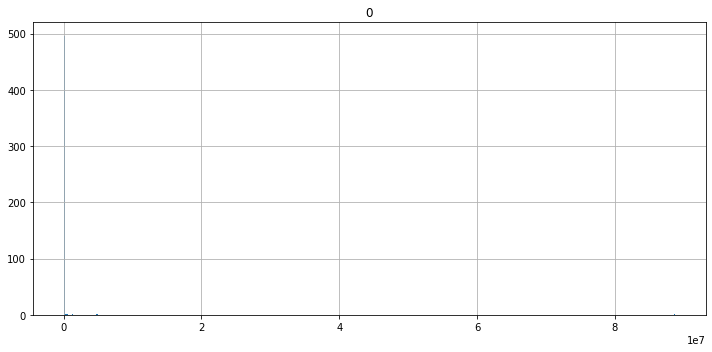

In [54]:
hist_df = pd.DataFrame(hist)
hist_df.hist(figsize=(10,5), bins=450)

### Notes
- [NetworkX docs on bipartite graphs](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html) However, if the input graph is not connected, there are more than one possible colorations. This is the reason why we require the user to pass a container with all nodes of one bipartite node set as an argument to most bipartite functions.
- Networkx uses a dictionary of dictionaries of dictionaries, as specified in the docs. NetworkX uses a “dictionary of dictionaries of dictionaries” as the basic network data structure. This allows fast lookup with reasonable storage for large sparse networks. The keys are nodes so G[u] returns an adjacency dictionary keyed by neighbor to the edge attribute dictionary. A view of the adjacency data structure is provided by the dict-like object G.adj as e.g. for node, nbrsdict in G.adj.items():. The expression G[u][v] returns the edge attribute dictionary itself. A dictionary of lists would have also been possible, but not allow fast edge detection nor convenient storage of edge data.